In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"] = "w"
sns.set_style('whitegrid')

## Линейная регрессия

In [3]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [4]:
X.shape, y.shape

((506, 13), (506,))

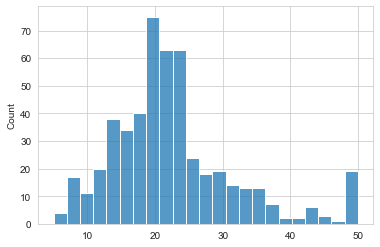

In [5]:
sns.histplot(y)
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [7]:
from sklearn.linear_model import LinearRegression

coefs_lr = LinearRegression().fit(X, y).coef_

In [8]:
coefs_lr

array([-0.92814606,  1.08156863,  0.1409    ,  0.68173972, -2.05671827,
        2.67423017,  0.01946607, -3.10404426,  2.66221764, -2.07678168,
       -2.06060666,  0.84926842, -3.74362713])

In [9]:
from scipy.stats import norm

def calc_LL(theta):
    std, w0, w = theta[0], theta[1], theta[2:]
    
    w = w.reshape((-1, 1))
    y_pred = X.dot(w) + w0
    y_pred = y_pred.reshape(-1)
    
    LL = np.sum(norm.logpdf(y, y_pred, std))
    
    return -LL

In [10]:
theta0 = np.random.randn(2+X.shape[1])
theta0[0] = 1

In [11]:
calc_LL(theta0)

167777.30057958007

In [12]:
from scipy.optimize import minimize

solution = minimize(calc_LL, theta0, method='L-BFGS-B')
solution.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [13]:
coefs_ll = solution.x[2:]

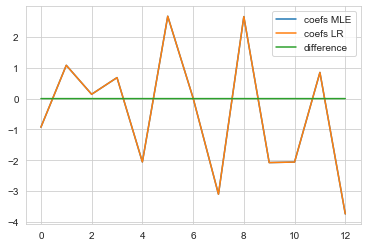

In [14]:
plt.plot(coefs_ll, label='coefs MLE')
plt.plot(coefs_lr, label='coefs LR')
plt.plot(coefs_lr - coefs_ll, label='difference')
plt.legend(loc=1)
plt.show()

## Поиск аномалий

In [15]:
np.random.seed(123)

In [16]:
mu_real = [1, 2]
sigma_real = [[2, 2], [2, 4]]
data = np.random.multivariate_normal(mu_real, sigma_real, 100)
data = np.vstack((data, [[-3, 4], [3, -2]]))

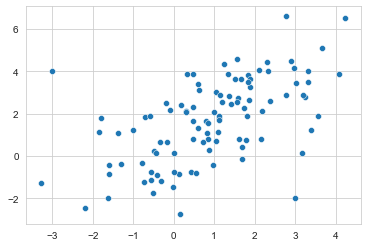

In [17]:
sns.scatterplot(x=data[:, 0], y=data[:, 1])
plt.show()

In [18]:
mu = data.mean(axis=0)

In [19]:
mu

array([0.91591574, 1.67510663])

In [20]:
mu_real

[1, 2]

In [21]:
sigma = (data - mu).T.dot(data - mu) / len(data)

In [22]:
sigma

array([[2.36709296, 1.71039097],
       [1.71039097, 3.86672716]])

In [23]:
sigma_real

[[2, 2], [2, 4]]

In [24]:
from scipy.stats import multivariate_normal

pdf_data = multivariate_normal(mu, sigma).pdf(data)

In [25]:
threshold = np.percentile(pdf_data, q=5)
mask = pdf_data < threshold

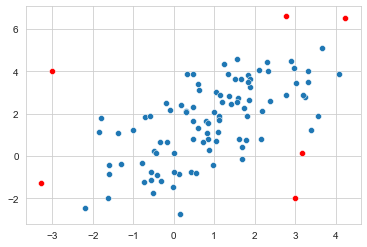

In [26]:
sns.scatterplot(x=data[~mask, 0], y=data[~mask, 1])
sns.scatterplot(x=data[mask, 0], y=data[mask, 1], color='red')
plt.show()

## Ядерные оценки

<Figure size 720x216 with 0 Axes>

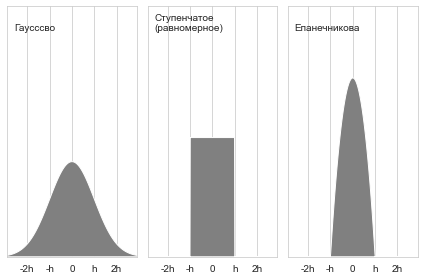

In [27]:
from sklearn.neighbors import KernelDensity

X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

plt.figure(figsize=(10, 3))
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x
    
names = {
    "gaussian": 'Гауcсcво',
    "tophat": 'Ступенчатое\n(равномерное)',
    "epanechnikov": 'Епанечникова'
}


for i, kernel in enumerate(
    ["gaussian", "tophat", "epanechnikov"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="grey")
    axi.text(-2.6, 0.95, names[kernel])

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)
    
plt.tight_layout()
plt.savefig('kernels.pdf')
plt.show()

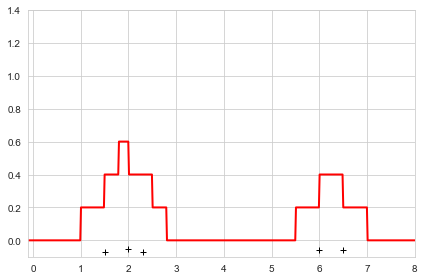

In [28]:
X = np.array([1.5, 2, 2.3, 6, 6.5])
X = X[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

# true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
# ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

kde = KernelDensity(kernel="tophat", bandwidth=0.5).fit(X)
log_dens = kde.score_samples(X_plot)
ax.plot(
    X_plot[:, 0],
    np.exp(log_dens),
    color='red',
    lw=lw,
    linestyle="-",
    label="kernel = '{0}'".format(kernel),
)

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('tophat.pdf')
plt.show()

## Иллюстрации ядерной оценки

In [29]:
X = np.array([1.5, 2, 2.3, 6, 6.5])

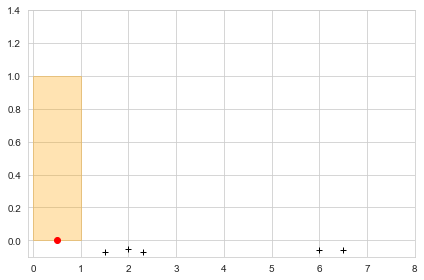

In [30]:
fig, ax = plt.subplots()
plt.fill([0, 0, 1, 1], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo1.pdf')
plt.show()

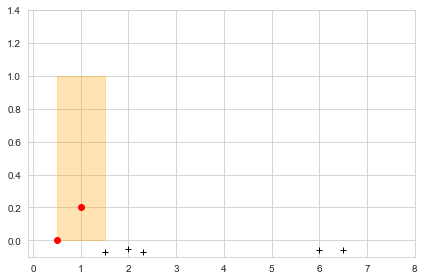

In [31]:
fig, ax = plt.subplots()
plt.fill([0.5, 0.5, 1.5, 1.5], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo2.pdf')
plt.show()

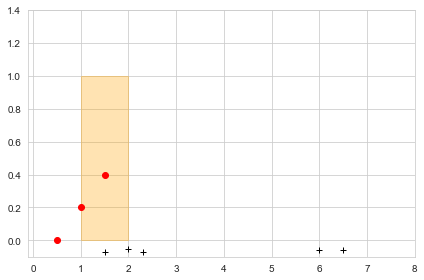

In [32]:
fig, ax = plt.subplots()
plt.fill([1, 1, 2, 2], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo3.pdf')
plt.show()

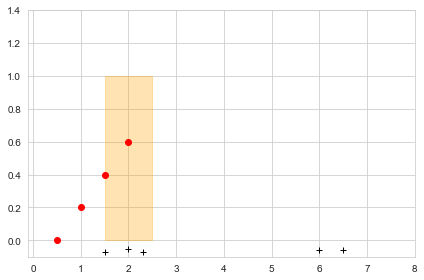

In [33]:
fig, ax = plt.subplots()
plt.fill([1.5, 1.5, 2.5, 2.5], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')
plt.plot(2, 0.6, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo4.pdf')
plt.show()

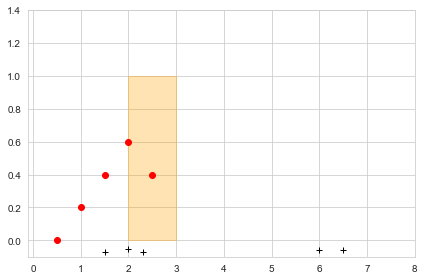

In [34]:
fig, ax = plt.subplots()
plt.fill([2, 2, 3, 3], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')
plt.plot(2, 0.6, 'ro')
plt.plot(2.5, 0.4, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo5.pdf')
plt.show()

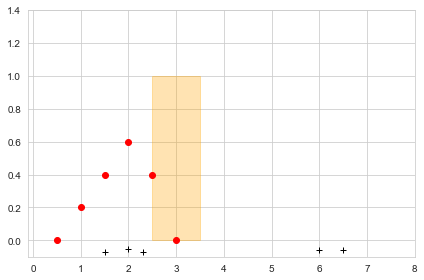

In [35]:
fig, ax = plt.subplots()
plt.fill([2.5, 2.5, 3.5, 3.5], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')
plt.plot(2, 0.6, 'ro')
plt.plot(2.5, 0.4, 'ro')
plt.plot(3, 0, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo5.pdf')
plt.show()

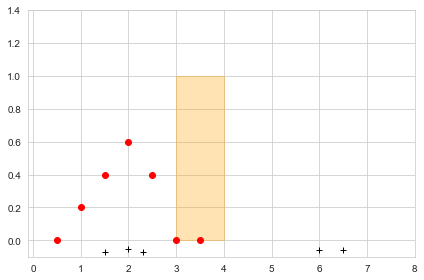

In [36]:
fig, ax = plt.subplots()
plt.fill([3, 3, 4, 4], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')
plt.plot(2, 0.6, 'ro')
plt.plot(2.5, 0.4, 'ro')
plt.plot(3, 0, 'ro')
plt.plot(3.5, 0, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo6.pdf')
plt.show()

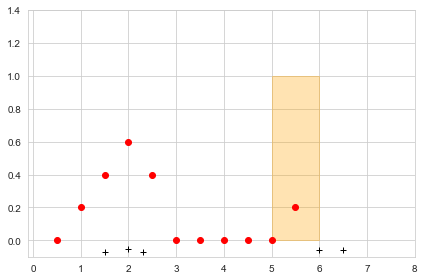

In [37]:
fig, ax = plt.subplots()
plt.fill([5, 5, 6, 6], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')
plt.plot(2, 0.6, 'ro')
plt.plot(2.5, 0.4, 'ro')
plt.plot(3, 0, 'ro')
plt.plot(3.5, 0, 'ro')
plt.plot(4, 0, 'ro')
plt.plot(4.5, 0, 'ro')
plt.plot(5, 0, 'ro')
plt.plot(5.5, 0.2, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo7.pdf')
plt.show()

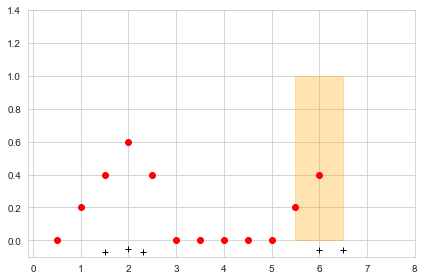

In [38]:
fig, ax = plt.subplots()
plt.fill([5.5, 5.5, 6.5, 6.5], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')
plt.plot(2, 0.6, 'ro')
plt.plot(2.5, 0.4, 'ro')
plt.plot(3, 0, 'ro')
plt.plot(3.5, 0, 'ro')
plt.plot(4, 0, 'ro')
plt.plot(4.5, 0, 'ro')
plt.plot(5, 0, 'ro')
plt.plot(5.5, 0.2, 'ro')
plt.plot(6, 0.4, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo8.pdf')
plt.show()

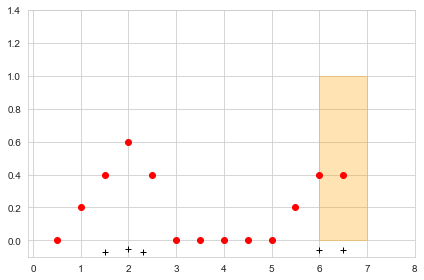

In [39]:
fig, ax = plt.subplots()
plt.fill([6, 6, 7, 7], [0, 1, 1, 0], color='orange', alpha=0.3)
plt.plot(0.5, 0, 'ro')
plt.plot(1, 0.2, 'ro')
plt.plot(1.5, 0.4, 'ro')
plt.plot(2, 0.6, 'ro')
plt.plot(2.5, 0.4, 'ro')
plt.plot(3, 0, 'ro')
plt.plot(3.5, 0, 'ro')
plt.plot(4, 0, 'ro')
plt.plot(4.5, 0, 'ro')
plt.plot(5, 0, 'ro')
plt.plot(5.5, 0.2, 'ro')
plt.plot(6, 0.4, 'ro')
plt.plot(6.5, 0.4, 'ro')

np.random.seed(4)
ax.plot(X, -0.025 - 0.05 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-0.1, 8)
ax.set_ylim(-0.1, 1.4)

plt.tight_layout()
plt.savefig('demo9.pdf')
plt.show()

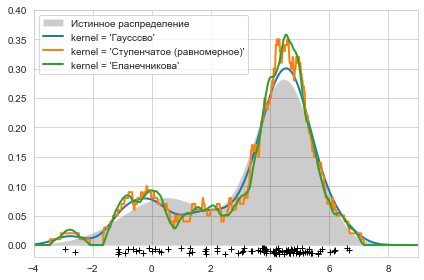

In [40]:
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0.5, 1.5, int(0.3 * N)), np.random.normal(4.5, 1, int(0.7 * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0.5, 1.5).pdf(X_plot[:, 0]) + 0.7 * norm(4.5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="Истинное распределение")
# colors = ["green", "red", "blue"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

names = {
    "gaussian": 'Гауcсcво',
    "tophat": 'Ступенчатое (равномерное)',
    "epanechnikov": 'Епанечникова'
}

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
#         color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(names[kernel]),
    )

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)

plt.tight_layout()
plt.savefig('all_demo1.pdf')
plt.show()

## Снова поиск аномалий

In [41]:
np.random.seed(123)

In [42]:
mu_real = [1, 2]
sigma_real = [[2, 2], [2, 4]]
data = np.random.multivariate_normal(mu, sigma, 100)
data = np.vstack((data, [[-3, 4], [3, -2]]))

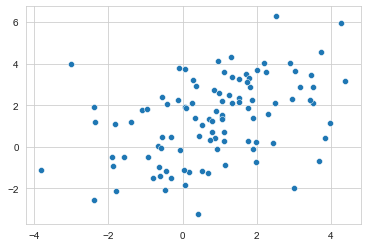

In [43]:
sns.scatterplot(x=data[:, 0], y=data[:, 1])
plt.show()

In [44]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='epanechnikov', bandwidth=2).fit(data)
log_dens = kde.score_samples(data)

In [45]:
threshold = np.percentile(log_dens, q=5)
mask = log_dens < threshold

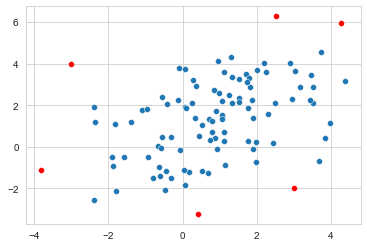

In [46]:
sns.scatterplot(x=data[~mask, 0], y=data[~mask, 1])
sns.scatterplot(x=data[mask, 0], y=data[mask, 1], color='red')
plt.show()